# Common Libraries

In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

from sklearn.decomposition import PCA, KernelPCA
import util

# Load Dataset


Read the date, and 8 yields (1,2,3,5,10,20,30 year) in to a data frame.
Then filter out any rows with null values for any of the above 8 yields.
Make the Date the index in this input data frame.
Find, the end of month dates for the year range of the input data frame.
Filter and keep only the rows for the end of the month date.


In [2]:
%matplotlib inline
df = pd.read_csv('yield_curves.csv', sep=' *, *')
df = df.replace({'na': np.nan})
df = df.apply(pd.to_numeric, errors='ignore')

# Remove the last column due to the last comma
df = df.iloc[:, :-1]
df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True)
df.set_index('Date', drop=True, inplace=True)

# drop na rows
df = df.dropna()

min_year = df.index.min().year
max_year = df.index.max().year

last_day_of_month = util.lastdayofmonth(min_year, max_year)
last_day_of_month.set_index('Date', drop=True, inplace=True)

i1 = df.index
i2 = last_day_of_month.index
df_monthly_samples = df[i1.isin(i2)]

df_selected_yields = df_monthly_samples.loc[:,["ZC100YR", "ZC200YR", "ZC300YR", "ZC500YR", "ZC1000YR", "ZC1500YR", "ZC2000YR", "ZC3000YR"]]
df_selected_yields.columns = ["1YR", "2YR", "3YR", "5YR", "10YR", "15YR", "20YR", "30YR"]

# Projection onto Principal Components
Use Kernel PCA for better accuracy

# Kernel PCA

In [3]:
pcaA = KernelPCA(n_components=3,
                 kernel='rbf',
                 gamma=4,
                 kernel_params=None,
                 fit_inverse_transform=False,
                 eigen_solver='auto',
                 tol=0,
                 max_iter=None)

pcaA.fit(df_selected_yields)
dpca = pd.DataFrame(pcaA.transform(df_selected_yields))
dpca.index = df_selected_yields.index

The objective is to model how yield curve move with the changes in PCA 1.
The alogrithm (later extend to multiple output ANFIS) is using single output ANFIS and calculate each yield seperately. Therefore the error function is not optimal as with all outputs together.
For the moment, only 5 year yield is predicted.


The current state is represented by PCA. 
Change in PCA 1 is calculated by substracting from the next month PCA 1.
Expected output is change in the yield curve.


ANFIS Model
ANFIS  inputs = PC1 (t), PC2 (t), Delta PCA 1 (t + delta t)
ANFIS  output = Delta Y (t + delta t)
Each input is represented by 4 gaussian membership functions.

TODO
Modify the alogrithm to train the 8 yields together, so the ANFIS is generalized for mutliple yields
ANFIS  inputs = PC1 (t), PC2 (t), Delta PCA 1 (t + delta t)
ANFIS  output = Delta Y1 (t + delta t), Delta Y2 (t + delta t) ... Delta Y8 (t + delta t)



In [4]:
delta_pca = dpca.diff()
df_input = pd.merge(dpca, delta_pca, on='Date')

df_selected_yields_delta = df_selected_yields.diff()

Import the ANFIS classes
Copied from https://github.com/twmeggs/anfis
Will extensively modify/extend and send a pull request

In [5]:
import anfis
import mfDerivs
import membershipfunction

Convert the data frames to numpy arrays as expected by the ANFIS library

In [6]:
# df_input contains PC1, PC2, and Delta PC1
ts = df_input.to_numpy()
X = ts[1:, 0:3]

df_selected_yields_delta_filtered = df_selected_yields_delta.iloc[1:, 0:]
Y = np.stack(df_selected_yields_delta_filtered.to_numpy())


Define the membership functions. Four per each variable, PC1, PC2, Delta PC1

In [7]:
import os

mf = {}
mf["gauss_4"] = [
    [['gaussmf',{'mean':0.2,'sigma':0.1}],['gaussmf',{'mean':0.4,'sigma':0.1}],['gaussmf',{'mean':0.6,'sigma':0.1}],['gaussmf',{'mean':0.8,'sigma':0.1}]],
    [['gaussmf',{'mean':0.2,'sigma':0.1}],['gaussmf',{'mean':0.4,'sigma':0.1}],['gaussmf',{'mean':0.6,'sigma':0.1}],['gaussmf',{'mean':0.8,'sigma':0.1}]],
    [['gaussmf',{'mean':0.2,'sigma':0.1}],['gaussmf',{'mean':0.4,'sigma':0.1}],['gaussmf',{'mean':0.6,'sigma':0.1}],['gaussmf',{'mean':0.8,'sigma':0.1}]]
    ]
mf["gauss_3"] = [
    [['gaussmf',{'mean':0.2,'sigma':0.1}],['gaussmf',{'mean':0.2,'sigma':0.1}],['gaussmf',{'mean':0.2,'sigma':0.1}]],
    [['gaussmf',{'mean':0.2,'sigma':0.1}],['gaussmf',{'mean':0.2,'sigma':0.1}],['gaussmf',{'mean':0.2,'sigma':0.1}]],
    [['gaussmf',{'mean':0.2,'sigma':0.1}],['gaussmf',{'mean':0.2,'sigma':0.1}],['gaussmf',{'mean':0.2,'sigma':0.1}]]
    ]
mf["gbell_4"] = [
    [['gbellmf',{'a':4,'b':2,'c':0.1}],['gbellmf',{'a':4,'b':2,'c':0.6}],['gbellmf',{'a':4,'b':2,'c':0.8}],['gbellmf',{'a':4,'b':2,'c':1}]],
    [['gbellmf',{'a':4,'b':2,'c':0.1}],['gbellmf',{'a':4,'b':2,'c':0.6}],['gbellmf',{'a':4,'b':2,'c':0.8}],['gbellmf',{'a':4,'b':2,'c':1}]],
    [['gbellmf',{'a':4,'b':2,'c':0.1}],['gbellmf',{'a':4,'b':2,'c':0.6}],['gbellmf',{'a':4,'b':2,'c':0.8}],['gbellmf',{'a':4,'b':2,'c':1}]],
    ]

bell_mf_structure = "Bell b1 b2 b3"
gauss_mf_structure = "Gaussian b1 b2"
output_mf_structure = "Linear c1 c2 c3 c4"
tplFile = os.getcwd() + "/pfuzzy_tpl.fll"

experiments = []
experiments.append({'name':"gauss_4mf_5_epoch_0.001L",'num_input':3, 'num_output':8, 'mf_type':'Gaussian', 'tpl_file': tplFile, 'output_struct': output_mf_structure, 'mf_struct':gauss_mf_structure,'mf':mf["gauss_4"],'epochs':5,'alpha':0.001})
experiments.append({'name':"gauss_4mf_20_epoch_0.001L",'num_input':3, 'num_output':8, 'mf_type':'Gaussian', 'tpl_file': tplFile, 'output_struct': output_mf_structure, 'mf_struct':gauss_mf_structure,'mf':mf["gauss_4"],'epochs':20,'alpha':0.001})
experiments.append({'name':"gauss_4mf_25_epoch_0.001L",'num_input':3, 'num_output':8, 'mf_type':'Gaussian', 'tpl_file': tplFile, 'output_struct': output_mf_structure, 'mf_struct':gauss_mf_structure,'mf':mf["gauss_4"],'epochs':25,'alpha':0.001})
experiments.append({'name':"gauss_4mf_25_epoch_0.01L",'num_input':3, 'num_output':8, 'mf_type':'Gaussian', 'tpl_file': tplFile, 'output_struct': output_mf_structure, 'mf_struct':gauss_mf_structure,'mf':mf["gauss_4"],'epochs':25,'alpha':0.01})
experiments.append({'name':"gauss_4mf_25_epoch_0.0001L",'num_input':3, 'num_output':8, 'mf_type':'Gaussian', 'tpl_file': tplFile, 'output_struct': output_mf_structure, 'mf_struct':gauss_mf_structure,'mf':mf["gauss_4"],'epochs':25,'alpha':0.0001})
experiments.append({'name':"gauss_3mf_25_epoch_0.001L",'num_input':3, 'num_output':8, 'mf_type':'Gaussian', 'tpl_file': tplFile, 'output_struct': output_mf_structure, 'mf_struct':gauss_mf_structure,'mf':mf["gauss_3"],'epochs':25,'alpha':0.001})
experiments.append({'name':"gbell_4mf_25_epoch_0.001L",'num_input':3, 'num_output':8, 'mf_type':'Bell', 'tpl_file': tplFile, 'output_struct': output_mf_structure, 'mf_struct':bell_mf_structure,'mf':mf["gbell_4"],'epochs':25,'alpha':0.001})




In [8]:
from sklearn.model_selection import train_test_split
X_train, X_final_test, Y_train, Y_final_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [9]:
%matplotlib inline
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(X_train)

count = 1
test_data_splits = []
for train_index, test_index in kf.split(X):
    test_data_splits.append({"train_index": train_index, "validation_index": test_index})




In [10]:
import time
for idx, experiment in enumerate(experiments):
    print("Experiment Id " + str(idx))
    print("Experiment Name " + experiment["name"])
    mfc = membershipfunction.MemFuncs(experiment["mf"])
    test_run_results = []
    test_split = test_data_splits[idx]
    X_train, X_test = X[test_split["train_index"]], X[test_split["validation_index"]]
    Y_train, Y_test = Y[test_split["train_index"]], Y[test_split["validation_index"]]
    experiment["test_split"] = test_split
    # Train the ANFIS and collect the prediction
    start = time.time()
    anf = anfis.ANFIS(X_train, Y_train, mfc)
    anf.trainHybridJangOffLine(epochs=experiment["epochs"])
    experiment["training_time"] = time.time() - start
    experiment["training_error"] = anf.getTrainingError()
    experiment["consequents"] = anf.consequents
    experiment["mf"] = anf.memFuncs




92e-03
  -5.58502564e-03 -8.01372663e-05]
 [-1.13997598e-03  2.16909452e-04  2.44545687e-04 ...  1.78268393e-03
   2.11470150e-03 -3.31241763e-03]
 ...
 [-1.68833706e-02 -1.32643032e-02 -1.06665451e-02 ... -4.08402689e-03
  -5.56198503e-03 -6.58290638e-05]
 [-1.12929726e-03  2.14829595e-04  2.43674769e-04 ...  1.79856373e-03
   2.12278295e-03 -3.26819787e-03]
 [-5.56606488e-04 -5.02305321e-04 -4.75250469e-04 ... -3.75228809e-04
  -3.80077561e-04 -4.08879133e-04]]
(256, 8)
layerFive
[[-5.41737667e-04 -2.96479971e-04 -2.89524100e-04 ... -1.44452981e-04
   4.55620778e-07 -1.30429165e-03]
 [-5.67990503e-04 -3.32578930e-04 -3.19513437e-04 ... -1.76246582e-04
  -4.18587846e-05 -1.24848980e-03]
 [-4.06645220e-04 -2.18191974e-04 -2.28252560e-04 ... -1.58331170e-04
  -1.60038112e-05 -1.20495477e-03]
 ...
 [ 6.87281019e-04  4.73518350e-04  3.19515067e-04 ... -3.32329903e-05
   2.30729171e-05 -1.83593063e-04]
 [ 7.45078749e-04  5.20114818e-04  3.57093865e-04 ... -1.56991887e-05
   4.51821114e-05 

In [26]:
from fuzzylite import FllImporter
import re
import random

def text_replace(text, items_to_replace):
    rep = dict((re.escape(k), v) for k, v in items_to_replace.items()) 
    pattern = re.compile("|".join(items_to_replace.keys()))  
    return pattern.sub(lambda m: items_to_replace[re.escape(m.group(0))], text)

def prep_input_mf(num_input, mf_arr_all_inputs, mf_struct, mf_type):
    input_mf = []
    for ni in range(num_input):
        mf_str = ""
        mf_arr = mf_arr_all_inputs[ni]
        num_input_mf = len(mf_arr)
        for mf in range(num_input_mf):
            mf_values = mf_arr[mf][1]
            text_tpl = "term: in"+ str(ni+1) + "mf" + str(mf+1) + " " + mf_struct
            if mf_type == 'Gaussian':
                params = {"b1": str(mf_values["mean"]), "b2": str(mf_values["sigma"])}
            if mf_type == 'Bell':
                params = {"b1": str(mf_values["a"]), "b2": str(mf_values["b"]), "b3": str(mf_values["c"])}                
            if mf != 0:
                mf_str = mf_str + "\n" + "\t" 
            mf_str = mf_str + text_replace(text_tpl, params)
            mf_str = '' + mf_str + ''   
        input_mf.append(mf_str)
    return input_mf

def prep_output(num_output, num_output_mf, output_struct, consequents):
    out_str = ""
    for ni in range(num_output):
        mf_str = 'OutputVariable: out'+ str(ni+1)
        mf_str = (mf_str + "\n" 
        + "\t" + "enabled: true" + "\n"
        + "\t" + "range: -10.000 10.000" + "\n"
        + "\t" + "lock-range: false" + "\n"
        + "\t" + "aggregation: none" + "\n"
        + "\t" + "defuzzifier: WeightedAverage TakagiSugeno" + "\n"
        + "\t" + "default: nan" + "\n"
        + "\t" + "lock-previous: false")
        for mf in range(num_output_mf):
            text_tpl = "term: out"+ str(ni+1) + "mf" + str(mf+1) + " " + output_struct
            output_params = {"c1": str(consequents[mf*4, ni]), "c2": str(consequents[(mf*4) + 1, ni]), "c3": str(consequents[(mf*4) + 2, ni]), "c4": str(consequents[(mf*4) + 3, ni])}
            mf_str = mf_str + "\n" + "\t" 
            mf_str = mf_str + text_replace(text_tpl, output_params)
            mf_str = '' + mf_str + ''   
        if(ni == 0):
            out_str = mf_str
        else:
            out_str = out_str + "\n" + mf_str
    return out_str

def prep_rules(num_input_mf, num_output):
    rules_str = ""
    rule_num = 1
    for in1_mf in range(num_input_mf):
        for in2_mf in range(num_input_mf):
            for in3_mf in range(num_input_mf):
                rule_str = "rule: if in1 is in1mf" + str(in1_mf+1) + " and in2 is in2mf" + str(in2_mf+1) + " and in3 is in3mf" + str(in3_mf+1) 
                out_count = 1
                for ni in range(num_output):
                    if out_count == 1:
                        rule_str = rule_str + " then out1 is out1mf" + str(rule_num)
                    else:
                        rule_str = rule_str + " and out" + str(out_count) + " is out" + str(out_count) + "mf" + str(rule_num)
                    out_count = out_count + 1
                if rule_num == 1:
                    rules_str = rule_str
                else:
                    rules_str = rules_str + "\n" + "\t" + rule_str
                rule_num = rule_num + 1
                rules_str = '' + rules_str + ''
    return rules_str

def write_fill_file(tplFile, runFile, input_mf, out_str, rules_str):
    fin = open(tplFile, "rt")
    data = fin.read()
    #replace all occurrences of the required string
    data = data.replace('IN1', input_mf[0])
    data = data.replace('IN2', input_mf[1])
    data = data.replace('IN3', input_mf[2])
    data = data.replace('OUT', out_str)
    data = data.replace('RULES', rules_str)

    #close the input file
    fin.close()

    #open the input file in write mode
    fin = open(runFile, "wt")
    #overrite the input file with the resulting data
    fin.write(data)
    #close the file
    fin.close()

def init_fuzzy_engine(runFile):
    importer = FllImporter()
    with open(runFile, "r") as myfile:
        data_to_read = "".join(myfile.readlines()[1:])
    return importer.engine(data_to_read)

def prep_sample_consequents(num_output, num_output_mf):
    no_of_consequents_per_output = 4 * num_output_mf
    consequents = np.zeros(shape=(no_of_consequents_per_output,num_output))
    for row in range(no_of_consequents_per_output):
        consequents_row = []
        for col in range(num_output):
            consequents[row, col] = random.uniform(-1, 1)   
    return consequents

def setup_takagi_sugeno(experiment):
    runFileDir = "/tmp"
    mf_arr_all_inputs = experiment["mf"]
    mf_arr = mf_arr_all_inputs[0]
    num_input_mf = len(mf_arr)
    num_output_mf = 1
    num_output_mf = pow(num_input_mf, 3)
    input_mf = prep_input_mf(experiment["num_input"], mf_arr_all_inputs, experiment["mf_struct"], experiment["mf_type"])
    # if "consequents" not in experiment:
    #     experiment["consequents"] = prep_sample_consequents(num_output, num_output_mf)

    out_str = prep_output(experiment["num_output"], num_output_mf, experiment["output_struct"], experiment["consequents"])
    rules_str = prep_rules(num_input_mf, experiment["num_output"])
    runFile = runFileDir + "/" + experiment["name"] + ".fll"
    write_fill_file(experiment["tpl_file"], runFile, input_mf, out_str, rules_str)
    fuzzy_engine = init_fuzzy_engine(runFile)
    return fuzzy_engine

def predict_fuzzy(fuzzy_engine, X, num_output):
    predict_delta_y_arr = []
    for idx, s in enumerate(X):
        in1 = fuzzy_engine.variable("in1")
        in1.value = s[0]
        in2 = fuzzy_engine.variable("in2")
        in2.value = s[1]
        in3 = fuzzy_engine.variable("in3")
        in3.value = s[2]
        fuzzy_engine.process()
        pred = []
        for out_idx in range(num_output):
            out = fuzzy_engine.variable("out" + str(out_idx+1))
            if(math.isnan(out.value)):
                pred.append(0)
            else:
                print(out)
                pred.append(out.value)
        predict_delta_y_arr.append(pred)
    return predict_delta_y_arr    

def calc_error(predict_Y, actual_Y):
    return list(np.array(predict_Y) - np.array(actual_Y))

def calc_total_error(errors):
    return sum(sum(abs(x)) for x in errors)

#del experiments[7:len(experiments)]
experiments.append({'name':"untrained_gauss_4mf_25_epoch_0.001L",'num_input':3, 'num_output':8, 'mf_type':'Gaussian', 'tpl_file': tplFile, 'output_struct': output_mf_structure, 'mf_struct':gauss_mf_structure,'mf':mf["gauss_4"],'epochs':25,'alpha':0.001, 'consequents': prep_sample_consequents(8, 64), 'test_split': experiments[0]['test_split'],'training_time': 'untrained', 'training_error': 'untrained'})
 #print(experiments[8]["name"], experiments[8].keys())

for idx, experiment in enumerate(experiments):
    fuzzy_engine = setup_takagi_sugeno(experiment)
    test_split = experiment['test_split']
    X_train, X_test = X[test_split["train_index"]], X[test_split["validation_index"]]
    Y_train, Y_test = Y[test_split["train_index"]], Y[test_split["validation_index"]]
    start = time.time()
    experiment["predict_Y"] = predict_fuzzy(fuzzy_engine, X_test, experiment["num_output"])
    # print(predict_Y)
    experiment["validation_errors"] = calc_error(experiment["predict_Y"], Y_test)
    # print(errors)
    experiment["validation_time"] = time.time() - start
    experiment["validation_total_error"]  = calc_total_error(experiment["validation_errors"])
    experiment["validation_avg_error"]  = experiment["validation_total_error"]/experiment["num_output"]
    print(experiment["name"], "training_time = ", experiment["training_time"], "training_error = ", experiment["training_error"], "validation_time = ", experiment["validation_time"], "validation_avg_error = ",experiment["validation_avg_error"] )



 -0.350 -0.964
  term: out3mf6 Linear 0.702 -0.229 -0.861 0.277
  term: out3mf7 Linear 0.271 -0.824 0.801 0.174
  term: out3mf8 Linear -0.857 0.858 0.778 0.724
  term: out3mf9 Linear 0.737 0.220 0.038 0.018
  term: out3mf10 Linear -0.664 0.141 0.524 0.238
  term: out3mf11 Linear -0.714 -0.009 0.717 0.067
  term: out3mf12 Linear -0.414 -0.086 -0.443 0.077
  term: out3mf13 Linear -0.024 0.217 0.320 -0.437
  term: out3mf14 Linear -0.593 -0.488 -0.032 -0.189
  term: out3mf15 Linear 0.744 -0.832 0.430 0.708
  term: out3mf16 Linear 0.425 0.058 0.642 -0.616
  term: out3mf17 Linear -0.748 -0.887 -0.187 0.271
  term: out3mf18 Linear 0.076 0.855 -0.889 -0.002
  term: out3mf19 Linear 0.496 -0.724 0.072 0.368
  term: out3mf20 Linear 0.475 0.813 0.507 -0.193
  term: out3mf21 Linear -0.500 0.905 -0.891 0.743
  term: out3mf22 Linear 0.748 -0.555 0.058 0.095
  term: out3mf23 Linear -0.121 -0.889 -0.264 0.220
  term: out3mf24 Linear -0.952 -0.890 -0.513 0.722
  term: out3mf25 Linear 0.811 0.283 -0.953 

In [17]:
final_test = []
# 'untrained_gauss_4mf_25_epoch_0.001L' index is 7
final_test.append(experiments[7])
# 'untrained_gauss_4mf_25_epoch_0.001L' index is 7
final_test.append(experiments[1])
for idx, experiment in enumerate(final_test):
    fuzzy_engine = setup_takagi_sugeno(experiment)
    start = time.time()
    experiment["predict_Y"] = predict_fuzzy(fuzzy_engine, X_final_test, experiment["num_output"])
    # print(predict_Y)
    experiment["validation_errors"] = calc_error(experiment["predict_Y"], Y_final_test)
    # print(errors)
    experiment["validation_time"] = time.time() - start
    experiment["validation_total_error"]  = calc_total_error(experiment["validation_errors"])
    experiment["validation_avg_error"]  = experiment["validation_total_error"]/experiment["num_output"]
    print(experiment["name"], "training_time = ", experiment["training_time"], "training_error = ", experiment["training_error"], "validation_time = ", experiment["validation_time"], "validation_avg_error = ",experiment["validation_avg_error"] )

untrained_gauss_4mf_25_epoch_0.001L training_time =  untrained training_error =  untrained validation_time =  0.04338216781616211 validation_avg_error =  21.67933960679457
gauss_4mf_20_epoch_0.001L training_time =  759.2815380096436 training_error =  0.0020178637263051457 validation_time =  0.037636756896972656 validation_avg_error =  0.08298497918862649


In [18]:
all_data_test = []
# 'untrained_gauss_4mf_25_epoch_0.001L' index is 7
all_data_test.append(experiments[7])
# 'untrained_gauss_4mf_25_epoch_0.001L' index is 7
all_data_test.append(experiments[1])
for idx, experiment in enumerate(all_data_test):
    fuzzy_engine = setup_takagi_sugeno(experiment)
    start = time.time()
    experiment["predict_Y"] = predict_fuzzy(fuzzy_engine, X, experiment["num_output"])
    # print(predict_Y)
    experiment["validation_errors"] = calc_error(experiment["predict_Y"], Y)
    # print(errors)
    experiment["validation_time"] = time.time() - start
    experiment["validation_total_error"]  = calc_total_error(experiment["validation_errors"])
    experiment["validation_avg_error"]  = experiment["validation_total_error"]/experiment["num_output"]
    print(experiment["name"], "training_time = ", experiment["training_time"], "training_error = ", experiment["training_error"], "validation_time = ", experiment["validation_time"], "validation_avg_error = ",experiment["validation_avg_error"] )


untrained_gauss_4mf_25_epoch_0.001L training_time =  untrained training_error =  untrained validation_time =  0.191558837890625 validation_avg_error =  104.80461253294737
gauss_4mf_20_epoch_0.001L training_time =  759.2815380096436 training_error =  0.0020178637263051457 validation_time =  0.1850450038909912 validation_avg_error =  0.5174862607616472


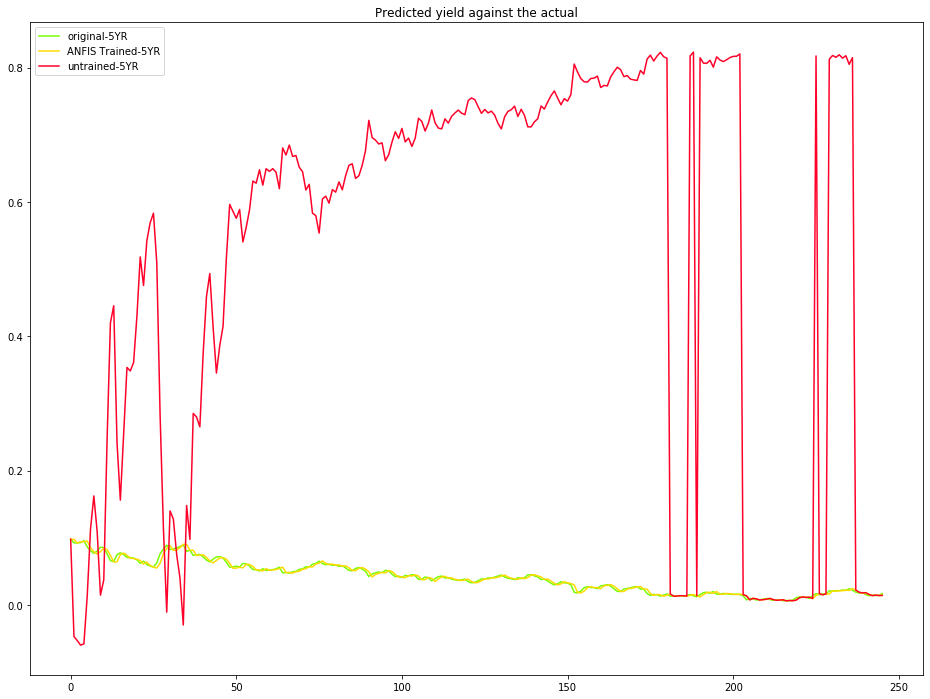

In [25]:
import random
%matplotlib inline

num_of_outputs = 3
fig = plt.figure(figsize=(16,12))
plt.title('Predicted yield against the actual')
cm = plt.get_cmap('gist_rainbow')

ax = fig.add_subplot(111)
NUM_COLORS = 16
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
random.shuffle(colors)
ax.set_prop_cycle(color=colors)

selected_yields_arr = df_selected_yields.to_numpy()

for yield_no in range(num_of_outputs, 4):
    ax.plot(range(len(selected_yields_arr)),selected_yields_arr[:, yield_no], label='original-'  + df_selected_yields.columns[yield_no])


def plot_predications(ax, label, num_of_outputs, df_selected_yields, predict_delta_y_arr):
    predict_yields = np.zeros(df_selected_yields.shape)

    for yield_no in range(7):
        predict_yields[0, yield_no] = df_selected_yields.iloc[0, yield_no]

    for idx, predict_delta_y in enumerate(predict_delta_y_arr):
        for yield_no in range(7):
            predict_yields[idx+1, yield_no] = selected_yields_arr[idx, yield_no] + predict_delta_y[yield_no]

    for yield_no in range(num_of_outputs, 4):
        ax.plot(range(len(predict_yields)), predict_yields[:, yield_no], label= label + '-' + df_selected_yields.columns[yield_no])

plot_predications(ax, 'ANFIS Trained', num_of_outputs, df_selected_yields, experiments[1]["predict_Y"])
plot_predications(ax, 'untrained', num_of_outputs, df_selected_yields, experiments[7]["predict_Y"])

plt.legend(loc='upper left')
plt.savefig("yeild_pred_compare_5yr.png")
